# Results for train/test split

Model 2c only



In [30]:
import time
import tellurium as te
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('../')


## Load data

In [31]:
# loading patient data
patient_ids = np.loadtxt('../id_samples_3_cycles.txt', dtype=int)
blood_counts = pd.read_csv('../patient_data_venex/blood_counts_table.csv')
bm_blasts = pd.read_csv('../patient_data_venex/blasts_table.csv')
cycle_days = pd.read_csv('../patient_data_venex/cycle_days.csv')

# loading patient information
# patient_data is not available for now, contact the authors.
patient_data = pd.read_csv('../patient_data_venex/ven_responses_052023.txt', sep='\t')
neut_blast_correlations = pd.read_csv('../output_data/neut_blast_treatment_correlations.csv', index_col=0)

In [32]:
m2c_param_data = pd.read_csv('../output_data/m2c_train_test_params_all_data.csv', index_col=0)
m2c_rmse_data = pd.read_csv('../output_data/m2c_train_test_rmse_all_data.csv', index_col=0)

In [33]:
m2c_rmse_data.shape

(188, 6)

### Separate data by number of training cycles

In [34]:
# mapping from patient to list of training cycle results  - dict of int : dict of int : row
patient_cycle_leuk_train = {}
patient_cycle_leuk_test = {}
patient_cycle_leuk_additional = {}
for index, row in m2c_rmse_data.iterrows():
    patient_id, n_train = index.split('_')
    patient_id = int(patient_id)
    n_train = int(n_train)
    if patient_id in patient_cycle_leuk_train:
        patient_cycle_leuk_train[patient_id][n_train] = row.leuk_train
        patient_cycle_leuk_test[patient_id][n_train] = row.leuk_test
        patient_cycle_leuk_additional[patient_id][n_train] = row.leuk_additional
    else:
        patient_cycle_leuk_train[patient_id] = {n_train: row.leuk_train}
        patient_cycle_leuk_test[patient_id] = {n_train: row.leuk_test}
        patient_cycle_leuk_additional[patient_id] = {n_train: row.leuk_additional}

In [35]:
patient_cycle_train_table = pd.DataFrame(patient_cycle_leuk_train).T
patient_cycle_test_table = pd.DataFrame(patient_cycle_leuk_test).T
patient_cycle_additional_table = pd.DataFrame(patient_cycle_leuk_additional).T

In [36]:
# select all patients that have all 5 cycles
selected_patients = ~patient_cycle_train_table.loc[:,5].isna()

In [37]:
patient_cycle_train_table = patient_cycle_train_table[selected_patients]
patient_cycle_test_table = patient_cycle_test_table[selected_patients]
patient_cycle_additional_table = patient_cycle_additional_table[selected_patients]

### Saving tables

In [38]:
patient_cycle_train_table.to_csv('patient_cycle_train_table.csv')
patient_cycle_test_table.to_csv('patient_cycle_test_table.csv')
patient_cycle_additional_table.to_csv('patient_cycle_additional_table.csv')

### Patient characteristics for selected patients

In [39]:
patient_data.index = patient_data.Study_subject_Id

In [40]:
selected_patient_data = patient_data.loc[selected_patients.index[selected_patients]]

In [41]:
selected_patient_data.columns

Index(['Study_subject_Id', 'incl_dg_for_tables', 'no_ven_therapy', 'prev_allo',
       'prev_hypomet_all', 'Gender', 'age_group_scr', 'ecog_scr', 'hb_scr',
       'leuk_scr', 'neut_all_scr', 'trom_scr', 'ld_scr', 'b_blasts_scr',
       'blasts_bm_scr', 'fab', 'del_5', 'del_5q', 'del_7', 'del_7q', 'del_17p',
       'complex', 'monosomal', 'HR_karyotype', 'karyotype_normal', 'NPM1',
       'FLT3_tkd', 'FLT3_itd', 'FLT3_rat', 'CEBPA', 'DNMT3A', 'IDH1', 'IDH2',
       'TET2', 'RUNX1', 'SRSF2', 'TP53', 'ASXL1', 'BCOR', 'CDKN2A', 'CREBBP',
       'CUX1', 'EP300', 'ETV6', 'EZH2', 'GATA2', 'KDM6A', 'NF1', 'RAD21',
       'SETD2', 'STAG2', 'XRSR2', 'BRAF', 'CALR', 'CBL', 'CSF3R', 'GATA1',
       'JAK2', 'KIT', 'KRAS', 'NRAS', 'MPL', 'PDGFRA', 'PHF6', 'PTPN11',
       'SETBP1', 'SF3B1', 'SMC1A', 'SMC3', 'U2AF1', 'WT1', 'c1_response',
       'c2_response', 'c3_response', 'best_response', 'mrd_neg', 'mrd_method',
       'relapse_occurred', 'eot_reason', 'eot_response', 'status',
       'OS_time_ve

In [42]:
selected_patient_data[['Gender', 'age_group_scr', 'status']].describe()

,Gender,age_group_scr,status
count,33,33,33
unique,2,2,2
top,Male,75 years or younger,Alive
freq,20,22,20


In [43]:
selected_patient_data[['OS_time_ven2_days', 'PFS_time_days']].describe()

,OS_time_ven2_days,PFS_time_days
count,33.000000,33.00000
mean,614.636364,534.30303
std,223.354793,246.73651
min,249.000000,215.00000
25%,442.000000,344.00000
50%,585.000000,533.00000
75%,702.000000,673.00000
max,1120.000000,1120.00000


In [44]:
selected_patient_data.groupby('best_response').agg('count')['Study_subject_Id']

best_response
CR      24
CRi      8
MLFS     1
Name: Study_subject_Id, dtype: int64

In [45]:
selected_patient_data.groupby('incl_dg_for_tables').agg('count')['Study_subject_Id']

incl_dg_for_tables
De novo / ND AML    25
R/R AML              6
sAML                 2
Name: Study_subject_Id, dtype: int64

## Comparisons of RMSE across different training/testing cycles

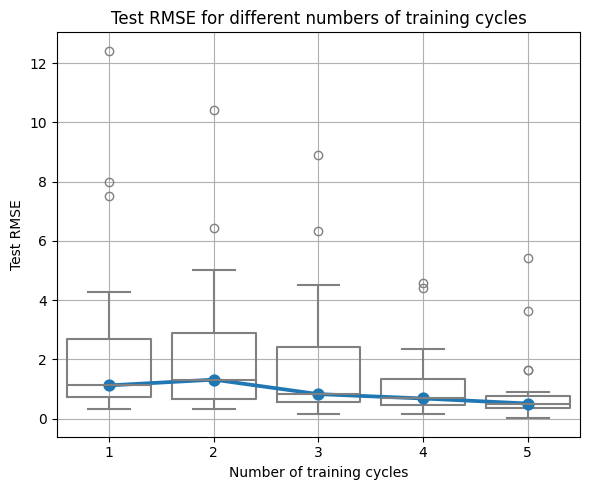

In [46]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.boxplot(data=patient_cycle_test_table, fill=False, color='gray', showfliers=True, ax=ax)
ax = sns.pointplot(data=patient_cycle_test_table, estimator='median', errorbar=None, ax=ax)
ax.grid()
ax.set_xlabel('Number of training cycles')
ax.set_ylabel('Test RMSE')
ax.set_title('Test RMSE for different numbers of training cycles')
plt.tight_layout()
plt.savefig('fig4_test_rmse_boxplot_with_outliers.png', dpi=300)
plt.show()

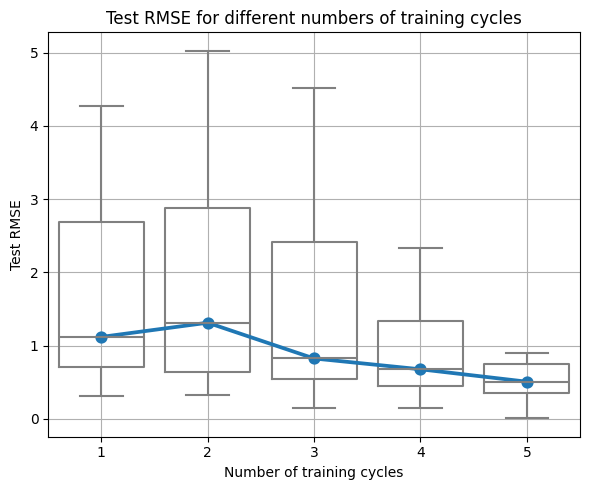

In [47]:
fig, ax = plt.subplots(figsize=(6,5))
ax = sns.boxplot(data=patient_cycle_test_table, fill=False, color='gray', showfliers=False, ax=ax)
ax = sns.pointplot(data=patient_cycle_test_table, estimator='median', errorbar=None, ax=ax)
ax.grid()
ax.set_xlabel('Number of training cycles')
ax.set_ylabel('Test RMSE')
ax.set_title('Test RMSE for different numbers of training cycles')
plt.tight_layout()
plt.savefig('fig4_test_rmse_boxplot_no_outliers.png', dpi=300)
plt.show()

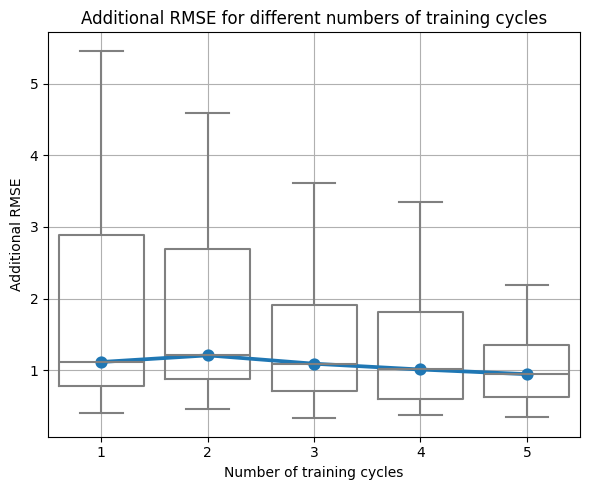

In [48]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.boxplot(data=patient_cycle_additional_table, fill=False, color='gray', showfliers=False, ax=ax)
ax = sns.pointplot(data=patient_cycle_additional_table, estimator='median', errorbar=None, ax=ax)
ax.grid()
ax.set_xlabel('Number of training cycles')
ax.set_ylabel('Additional RMSE')
ax.set_title('Additional RMSE for different numbers of training cycles')
plt.tight_layout()
plt.savefig('fig4_additional_rmse_boxplot_with_outliers.png', dpi=300)
plt.show()

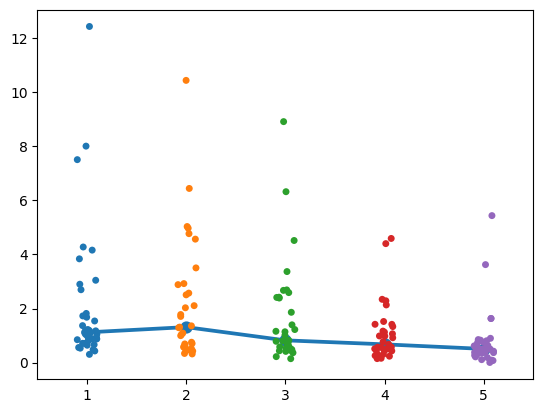

In [49]:
ax = sns.stripplot(data=patient_cycle_test_table)
ax = sns.pointplot(data=patient_cycle_test_table, estimator='median', errorbar=None, ax=ax)
#ax.set_ylim(0, 5)
plt.show()

In [50]:
train_data_long = patient_cycle_train_table.melt(ignore_index=False)
train_data_long.columns = ['cycles', 'rmse']
train_data_long['comparison'] = 'train'

test_data_long = patient_cycle_test_table.melt(ignore_index=False)
test_data_long.columns = ['cycles', 'rmse']
test_data_long['comparison'] = 'short-term test'

additional_data_long = patient_cycle_additional_table.melt(ignore_index=False)
additional_data_long.columns = ['cycles', 'rmse']
additional_data_long['comparison'] = 'long-term test'

concatenated_data_long = pd.concat([train_data_long, test_data_long, additional_data_long])

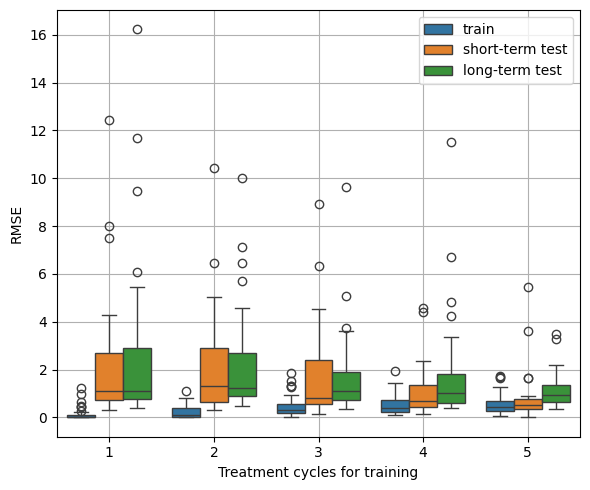

In [51]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.boxplot(data=concatenated_data_long, x='cycles', y='rmse', hue='comparison', ax=ax)
ax.grid()
#ax.set_title('RMSEs for different numbers of training cycles')
ax.set_ylabel('RMSE')
ax.set_xlabel('Treatment cycles for training')
ax.legend()
plt.tight_layout()
plt.savefig('fig4_train_test_additional_rmse_boxplots.png', dpi=300)
plt.show()

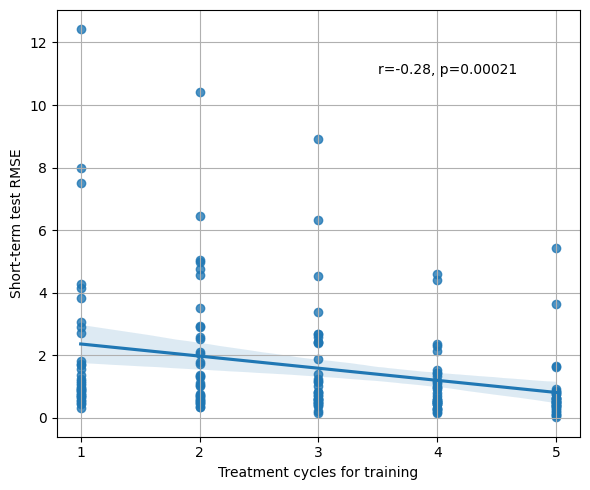

In [52]:
rr = scipy.stats.pearsonr(test_data_long.cycles, test_data_long.rmse)
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.regplot(data=test_data_long, x='cycles', y='rmse', ax=ax)
ax.grid()
# TODO: remove 1.5, 2.5 from xticks
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlabel('Treatment cycles for training')
ax.set_ylabel('Short-term test RMSE')
#ax.set_title('Short-term test RMSE vs number of training cycles')
ax.text(3.5, 11, 'r={:.2f}, p={:.2g}'.format(rr.statistic, rr.pvalue))
plt.tight_layout()
plt.savefig('fig4_test_regression.png', dpi=300)
plt.show()

In [53]:
scipy.stats.pearsonr(additional_data_long.cycles, additional_data_long.rmse)

PearsonRResult(statistic=-0.20334538817060707, pvalue=0.008803579214813152)

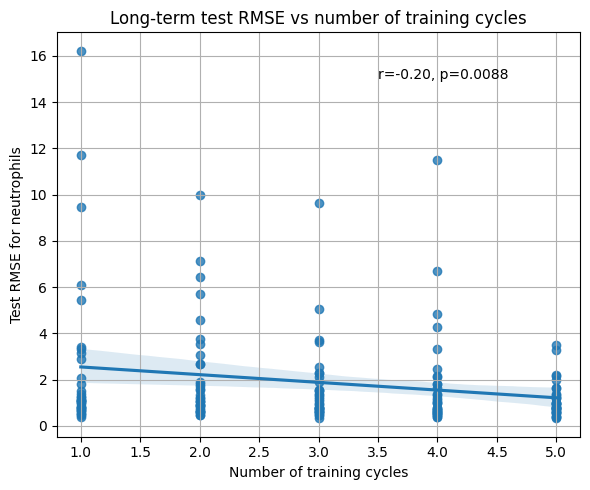

In [54]:
rr = scipy.stats.pearsonr(additional_data_long.cycles, additional_data_long.rmse)
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.regplot(data=additional_data_long, x='cycles', y='rmse', ax=ax)
ax.grid()
ax.set_xlabel('Number of training cycles')
ax.set_ylabel('Test RMSE for neutrophils')
ax.set_title('Long-term test RMSE vs number of training cycles')
ax.text(3.5, 15, 'r={:.2f}, p={:.2g}'.format(rr.statistic, rr.pvalue))
plt.tight_layout()
plt.savefig('fig4_additional_regression.png', dpi=300)
plt.show()

## Heatmap of test RMSE vs training cycles

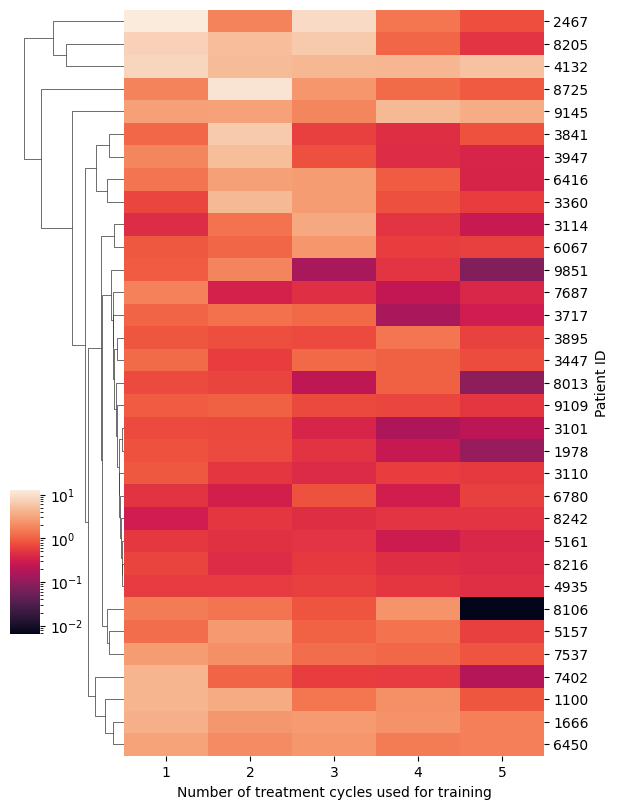

In [55]:
from matplotlib.colors import LogNorm


clustergrid = sns.clustermap(patient_cycle_test_table.values, xticklabels=patient_cycle_test_table.columns,
                             yticklabels=patient_cycle_test_table.index, #vmin=0, vmax=1, 
                             figsize=(6, 8),
                   cbar_pos=(0.01, 0.2, 0.05, 0.18),
                             norm=LogNorm(),
                             col_cluster=False,
                   dendrogram_ratio=(0.2, 0), 
                   )
clustergrid.ax_heatmap.set_xlabel('Number of treatment cycles used for training')
clustergrid.ax_heatmap.set_ylabel('Patient ID')

#plt.tight_layout()
clustergrid.savefig('fig3_cycles_patient_fvu_heatmap.png', dpi=300)

## Statistical analysis of parameter differences across training runs

Do the parameters change across runs? How should we analyze it?

## Plotting trajectories for selected patients

In [21]:
# for every patient, plot the data...
from systematic_model_comparisons_multiprocessing import MODELS
from new_patient_model import extract_data_from_tables_new, plot_data, calculate_errors, build_pm_model_from_dataframes,\
        split_cycles, run_model

In [49]:
patients_to_use = selected_patients.index[selected_patients]
patients_to_use = [3717, 3360]

In [50]:
model_functions = MODELS['m2c']
model_desc = model_functions['model_desc']
build_pm_model = model_functions['build_pm_model']
initialization_fn = model_functions['initialization_fn']
param_names = model_functions['param_names']
param_bounds = model_functions['param_bounds']
dosing_component = model_functions['dosing_component']

3717
n_samples: 600


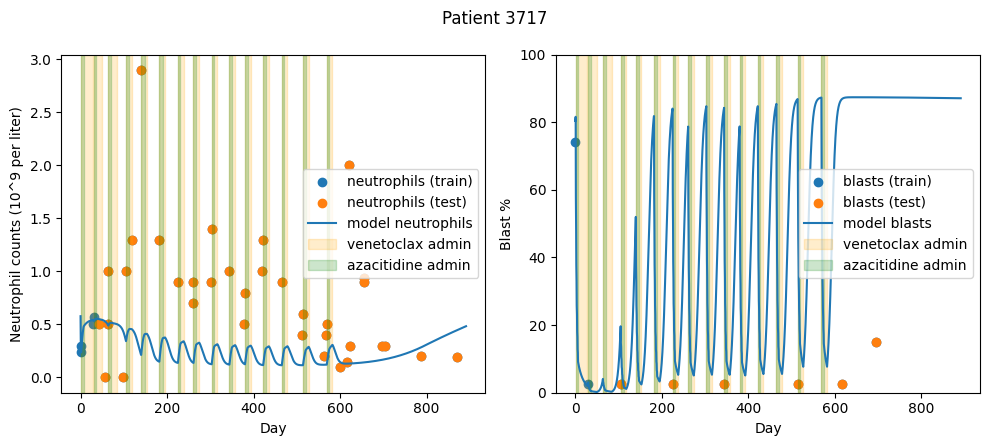

n_samples: 1280


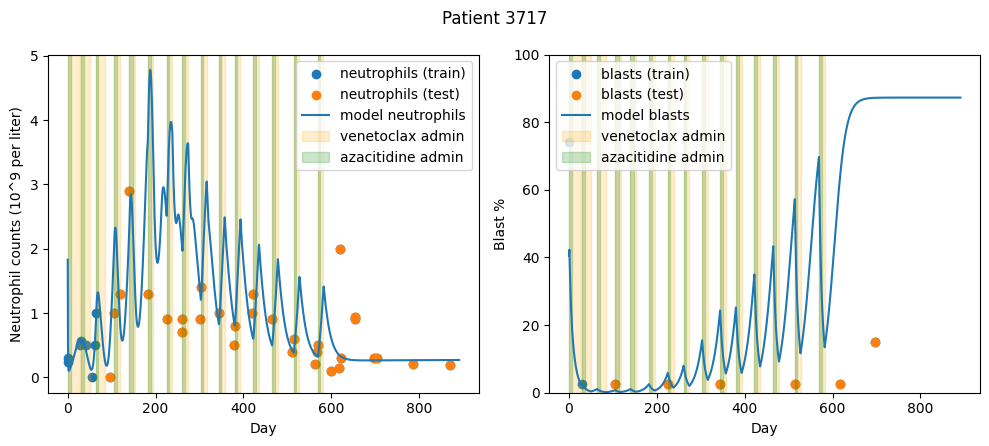

n_samples: 2100


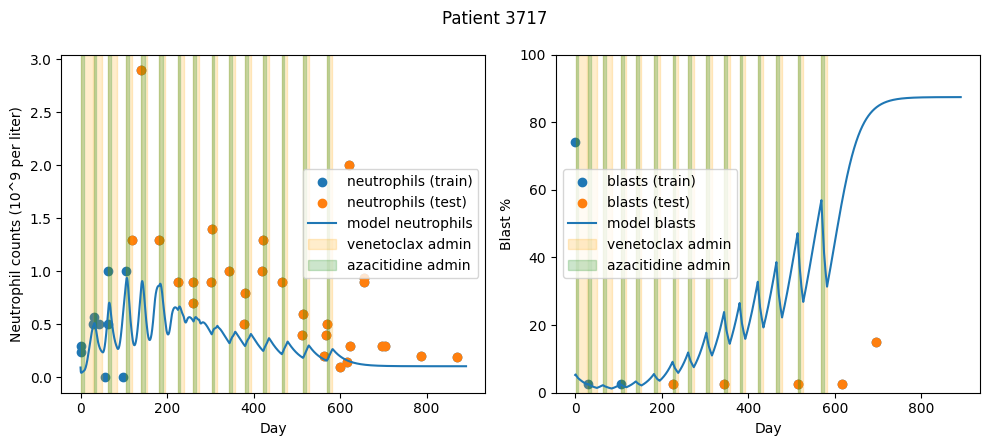

n_samples: 2800


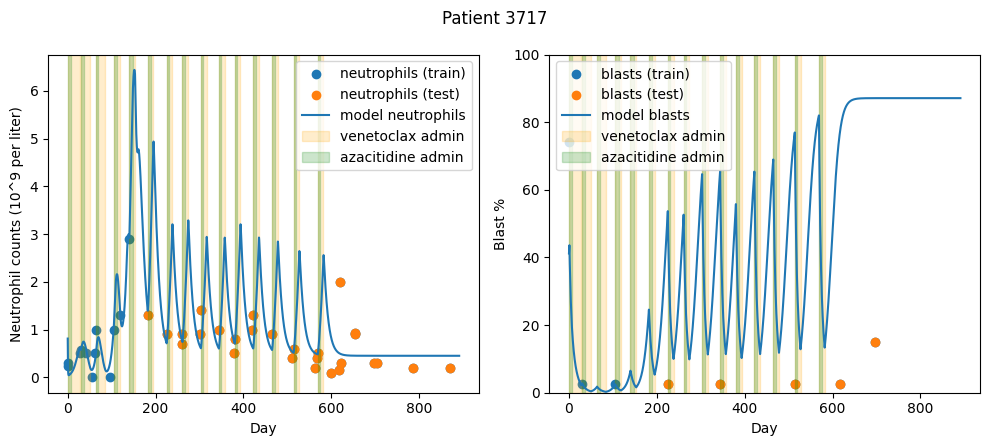

n_samples: 3640


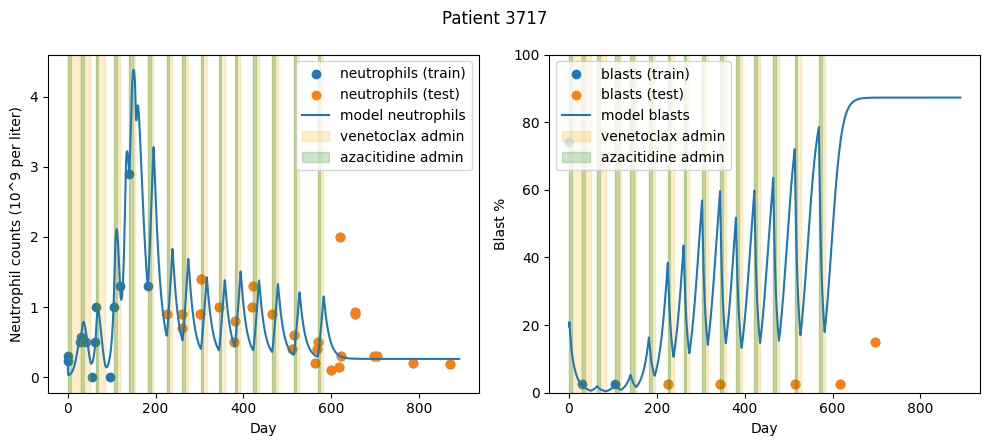

3360
n_samples: 860


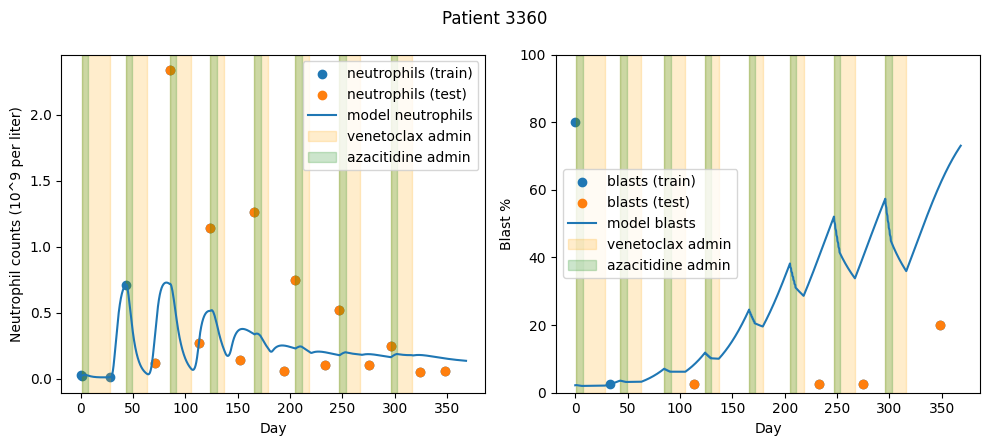

n_samples: 1700


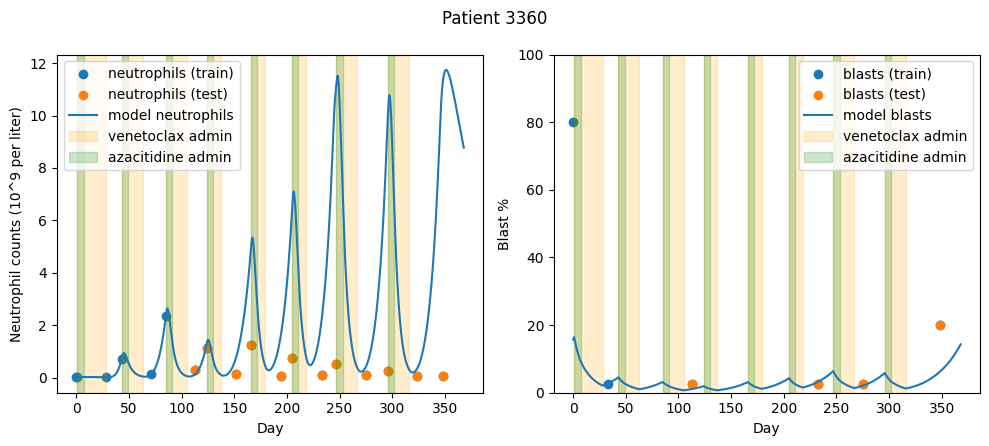

n_samples: 2480


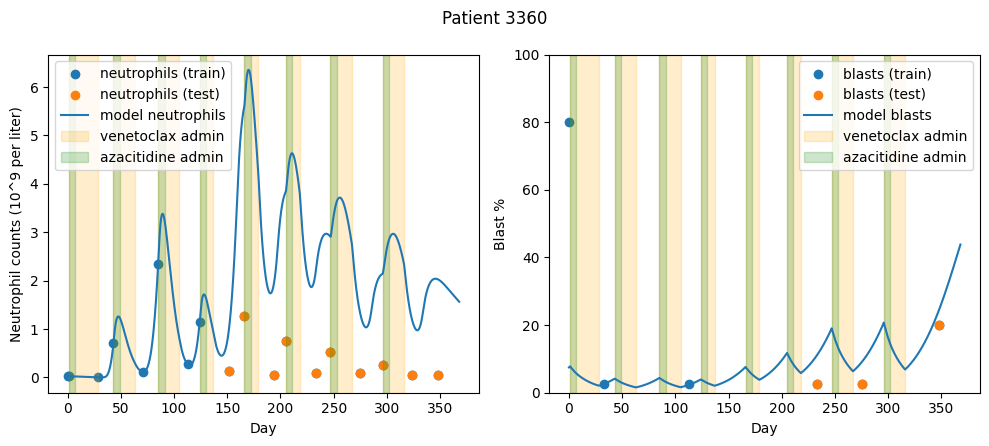

n_samples: 3320


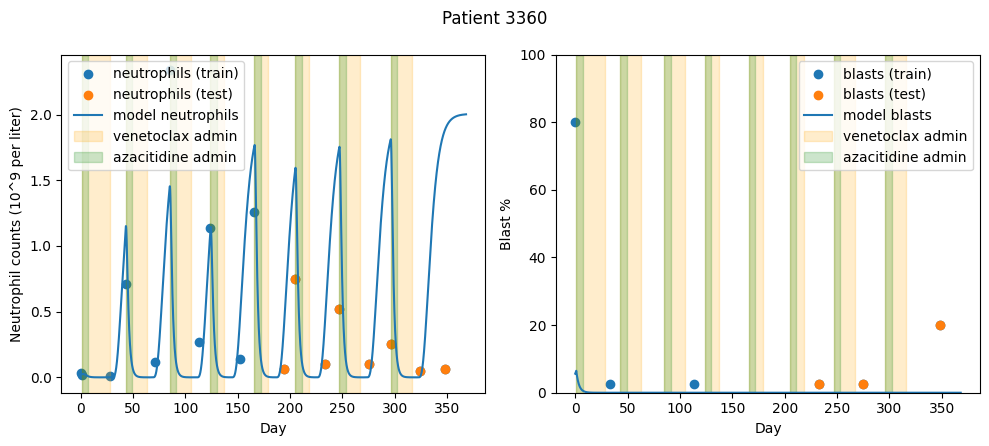

n_samples: 4100


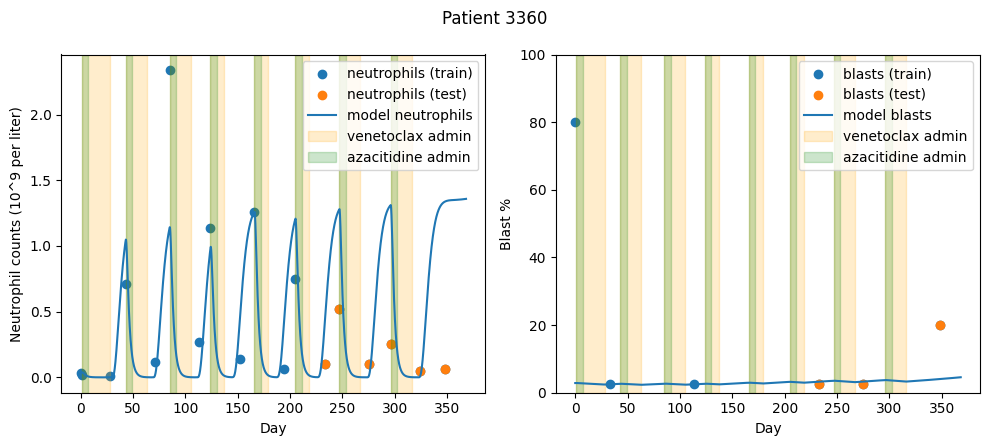

In [51]:
for patient_id in patients_to_use:
    print(patient_id)
    cycle_info, leuk_table, blast_table = extract_data_from_tables_new(blood_counts,
            bm_blasts, cycle_days, patient_id, use_neut=True)
    for cycle in range(1, 6):
        params = m2c_param_data.loc[f'{patient_id}_{cycle}']
        map_params = [params[k] for k in param_names]
        leuk_train, leuk_test, blast_train, blast_test, leuk_rem, blast_rem = split_cycles(leuk_table, blast_table, cycle_info,
                                                             n_cycles_train=cycle, n_cycles_test=2)
        te_model, pm_model = build_pm_model_from_dataframes(cycle_info, leuk_train, blast_train,
            use_neut=True, use_b0=True,
            model_desc=model_desc,
            build_model_function=build_pm_model,
            initialization=initialization_fn,
            dosing_component_function=dosing_component,
            params_to_fit=param_names,
            uniform_prior=True,
            use_initial_guess=True,
            )
        leuk_combined = pd.concat([leuk_test, leuk_rem])
        blast_combined = pd.concat([blast_test, blast_rem])
        max_time = max(cycle_info.days_ven_stop.max(), leuk_table.days_lab.max(), blast_table.days_from_bm.max()) + 20
        results = run_model(te_model, map_params, n_samples=max_time*1000, max_time=max_time, params_to_fit=param_names,
                            initialization=initialization_fn)
        plot_data(results, cycle_info, leuk_table, blast_table, patient_id, False, use_neut=True,
              leuk_table_test=leuk_combined, blast_table_test=blast_combined)